# Process the gravity data



In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from load_icgem import load_icgem_gdf

In [2]:
data = load_icgem_gdf('data/go_cons_gcf_2_tim_r5-africa-1deg.gdf')

In [3]:
data.keys()

['area', 'longitude', 'height', 'shape', 'latitude', 'gravity_ell', 'metadata']

In [4]:
print(data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2016/07/12
        product_type     gravity_field
                body     earth
           modelname     go_cons_gcf_2_tim_r5
     max_used_degree           280
         tide_system     tide_free
          functional     gravity_ell  (centrifugal term included)
                unit     mgal
          refsysname     WGS84
            gmrefpot      3.98600441800E+14 m**3/s**2
        radiusrefpot     6378137.000 m
          flatrefpot      3.352810664747480E-03   (1/298.25722356300)
         omegarefpot      7.29211500000E-05 1/s
       long_lat_unit     degree
      latlimit_north       40.000000000000    
      latlimit_south      -40.000000000000    
      longlimit_west      -20.000000000000    
      longlimit_east       55.000000000000    
            gridstep       1.0000000000000    
     height_over_ell       4000.0000 m
  latitude_parallels            81
 longitude_parallels            76
number_of_gridpoints       

In [7]:
lat = data['latitude']
lon = data['longitude']
height = data['height']
grav = data['gravity_ell']
shape = data['shape']
area = data['area']

In [8]:
print(area)

[-40.0, 40.0, -20.0, 55.0]


To choose colormaps:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://matplotlib.org/users/colormaps.html

(-20.0, 55.0)

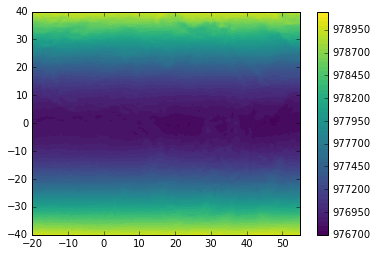

In [10]:
plt.figure()
plt.tricontourf(lon, lat, grav, 50, cmap='viridis')
plt.colorbar()
plt.xlim(area[2], area[3])